# This notebook generates figure 06, which shows a raw data comparison between 150 keV and 2400 keV data taken immediately one after the other proving that suppression does not require damage.

In [2]:
%pylab notebook
from scipy.optimize import curve_fit
import sys, os, importlib, warnings, pandas as pd, seaborn as sns
sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
warnings.filterwarnings("ignore")

import hts_fitting as hts, hts_fitfunctions as ff, hts_misc as misc, default_figure_style as dfs
for lib in [hts, dfs, ff, misc]:
    importlib.reload(lib)

outputDirectory = '../figures/raw/'


########## Load data ############
#################################
masterfile = '../data/data-master-linear.xlsx'
cols = [0, 12, 13,  41,  55, 56, 57, 59]
names = ['tapeid', 'energy', 'power', 'tTAR_OFF', 'suppression', 'suppressionError', 'suppression_corrected', 'outlier' ]
df = pd.read_excel(masterfile, sheet_name='data', usecols=cols, names=names, skiprows=1)


########## Filter data ##########
#################################
cut = df.tTAR_OFF <= 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1
data = df[cut]


########## Describe data ##########
###################################
print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())
df.columns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 676

Datapoints for f33 68

Datapoints for f20 14

Datapoints for f34 9

Datapoints for f29 302

Datapoints for f23 2

Datapoints for f28 58

Datapoints for f37 223


## Figure description

This figure compares compares two Faraday tapes (ffj29, ffj33) for which suppression was measured over an order of magnitude variation in atomic displacement rate, as calculated by SRIM. This figure shows that the beam on effect does not require a direct interaction of the beam with the sample (150 keV / 0 dpa/s case) and that it remains the same even if we increase the dpa rate by an order of magnitude. The two samples show different magnitude in suppression because of interface thermal resistance between tape and sample holder. The figure shows introduces the idea that thermal resistance is the controlling factor.

<IPython.core.display.Javascript object>


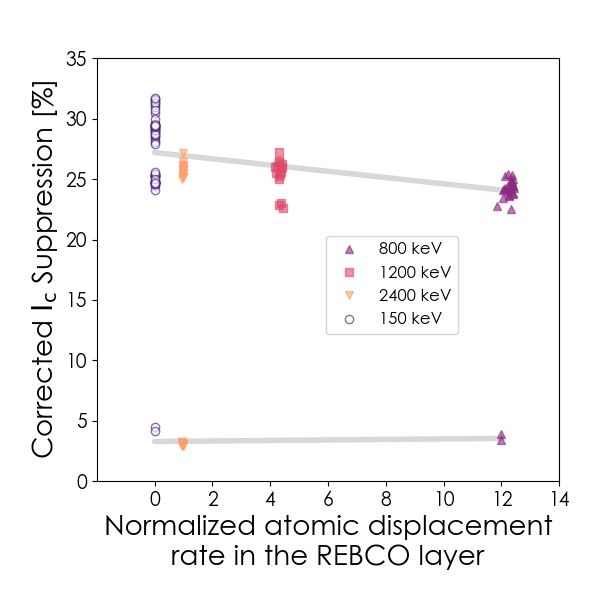

In [346]:
fitfunction = ff.linear

percent = 100 # switch suppression values to percentages

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
labels = ['800 keV', '1200 keV', '2400 keV', '150 keV']

# Creates a copy of the "energy" column with the displacement rate values in REBCO layer given by SRIM
displacementRates = [12.453497709306852, 4.427046491778315, 1.0, 0]
data['dpaRate'] = data['energy'].replace([800, 1200, 2400, 150], displacementRates)

for tape in ['f29', 'f33']:
    
    # Take a slide of the data where beam power is between 34 and 36 mW.
    cut = (data.tapeid == tape) & (34 < data.power) & (data.power < 36)
    x, y, energy = data.power[cut]*data.dpaRate[cut]/36, data.suppression_corrected[cut]*percent, data.energy[cut]
    
    # Fit a line throught all the energies for each sample
    popt, pcov = curve_fit(ff.linear, x, y)
    xsmooth = np.linspace(x.min(), x.max())
    ysmooth = ff.linear(xsmooth, *popt)
    ax.plot(xsmooth, ysmooth, linewidth=4, alpha=.3, color='gray', solid_capstyle='round')
    
    # Plot a cluster of point for each energy with jitter to reduce the overlap.
    for e, dr, m, l in zip([800, 1200, 2400, 150], displacementRates, ['^', 's', 'v', 'o'], labels):
        xdata, ydata, c = x[data.energy == e], y[data.energy == e], dfs.colors_energies[str(e)]
        if tape == 'f33': l = None
        if e == 150: 
            mfc = 'white'
        else:
            mfc = c
        ax.plot(xdata, ydata, alpha=0.6, color=c, mfc=mfc, markersize=6, marker=m, linestyle='None', label=l)

ax.legend(bbox_to_anchor=[0.8, 0.6])
ax.set_title(' ')
#ax.set_title('$\mathrm{P_{beam} = 36 \pm 2\,mW}$', fontsize=14)
ax.set_xlim(-2, 14)
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
ax.set_ylim(0, 35)
ax.set_ylabel('Corrected $\mathrm{I_c}$ Suppression [%]') # $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$
ax.set_xlabel('Normalized atomic displacement\nrate in the REBCO layer')
fig.tight_layout()
plt.savefig(outputDirectory+'figure07-150v2400v1200v800keV.svg', facecolor='white')